# 简介

- 根据用户数据特征，对用户进行PCA处理，找到累计概率超过95%的主成分
- 采用Kmeans对用户进行分类
- 对不同分类的用户进行探索性数据分析

# 读取数据

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
def pklsave(model, filename):
    """
    This function is to save the sklearn object
    INPUT :
        model : sklearn object
        filename : filepath to saved
    RETURN : none
    """
    pickle.dump(model, open(filename,'wb'))
    
def pklload(filename):
    """
    This function is to load the saved sklearn object
    INPUT : filename : filepath
    RETURN : loaded sklearn object
    """
    return pickle.load(open(filename, 'rb'))

In [4]:
profile_new =  pklload('sav/profile_new.sav')


# scale

In [5]:
# 函数 Feature Scaling ， 生成scale model
def perform_scaling(df):
    scaler = StandardScaler()
    std_arr = scaler.fit_transform(df)
    df_std = pd.DataFrame(std_arr, index=df.index, columns= df.columns)
    return df_std, scaler

profile_new_std , scaler_model= perform_scaling(profile_new)
pklsave(scaler_model, 'sav/scaler_model.sav')

# PCA

In [6]:
#%% PCA 
pca_model = PCA()
pca_model.fit(profile_new_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## 找95%主成分数

In [7]:
#%% PCA 累计曲线
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


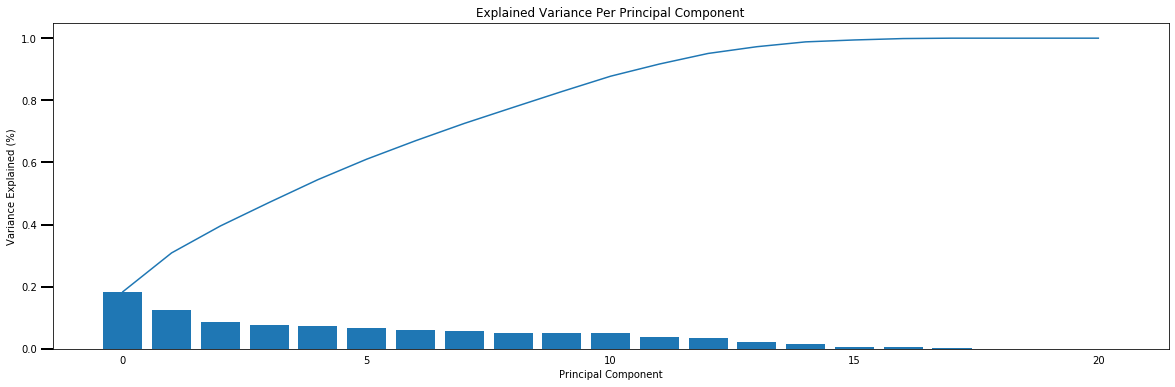

In [8]:
#%% PCA 
scree_plot(pca_model)

In [9]:
# PCA
cumvals = np.cumsum(pca_model.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

Number of Main PCA components that explained at least 95% variance : 13


In [10]:
#%% PCA 95 做成函数
def pca_fit_transform(df, var = None):
    pca = PCA(var)
    transform_arr = pca.fit_transform(df)
    return pca, transform_arr

pca_model, pca_transform = pca_fit_transform(profile_new_std, var=0.95)
pklsave(pca_model, 'sav/pca_model.sav')

## 主成分对应特征

In [11]:
#%% 函数 主成分对应col特征 做条形图
def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weights, features)
    return ax

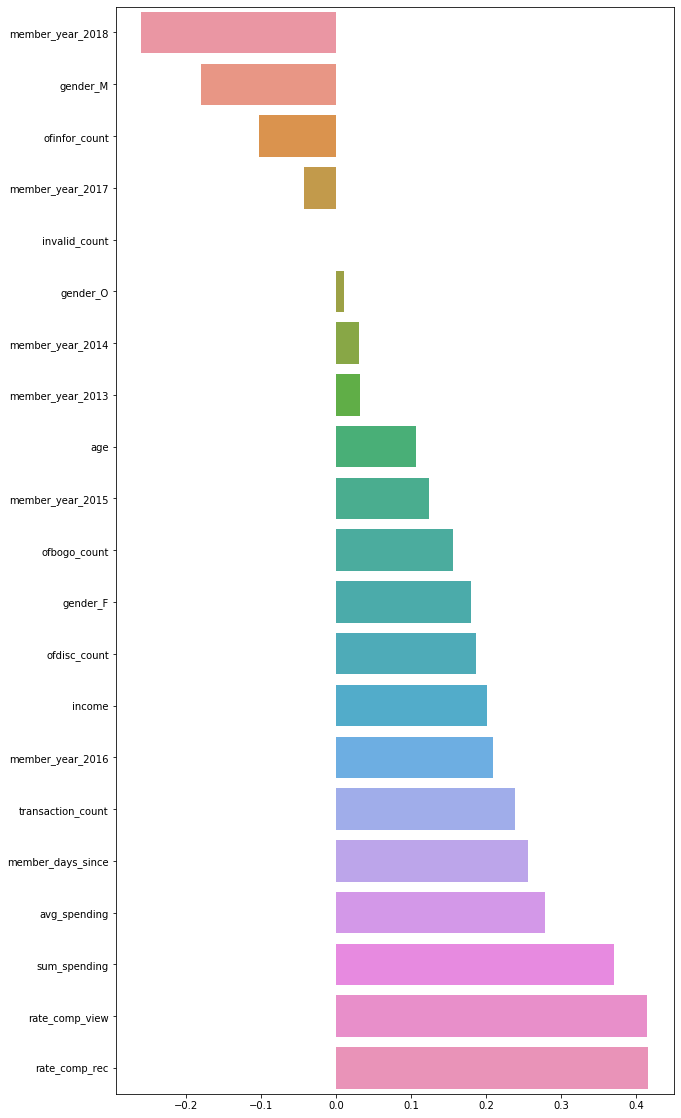

In [12]:
#%% 主成分1 作图 对于>100岁
plot_weight( profile_new_std, pca_model, 1 )


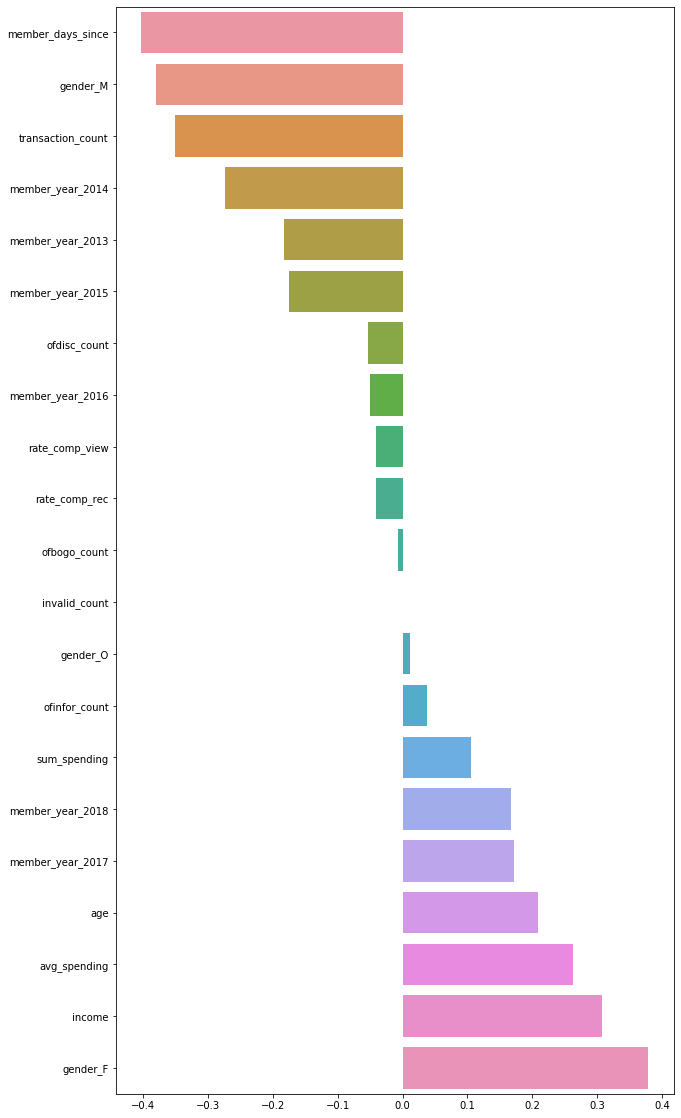

In [13]:
#%%  主成分2 作图
plot_weight(profile_new_std, pca_model , 2 )


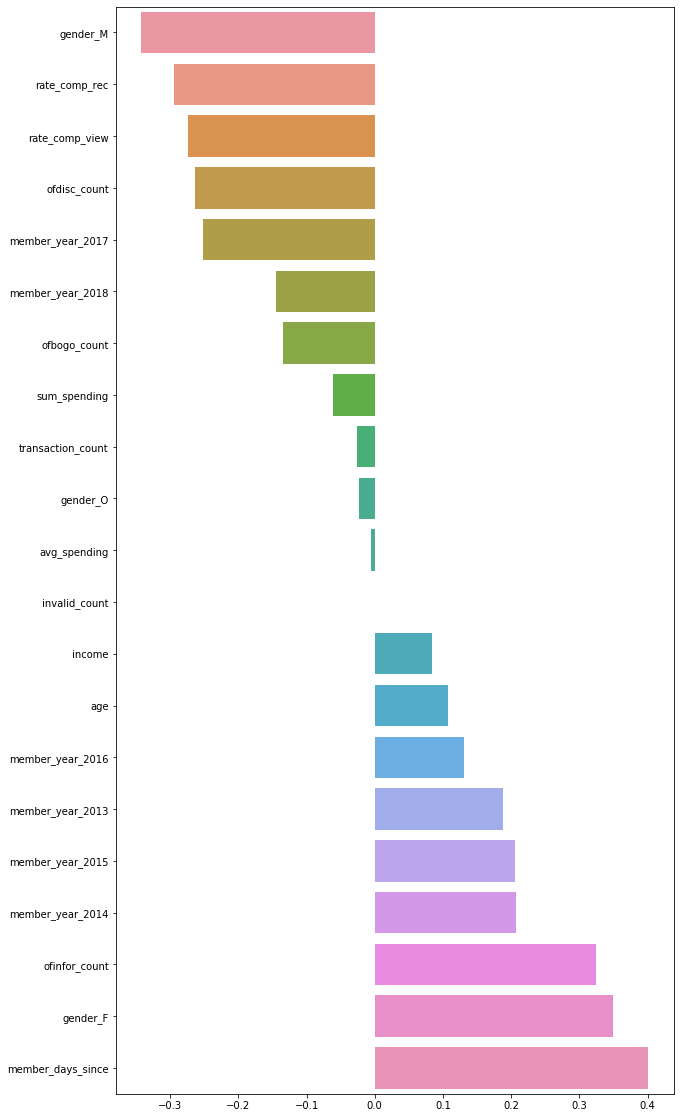

In [14]:
#%%  主成分3 作图
plot_weight(profile_new_std, pca_model , 3 )


# KMeans 分类

In [15]:
#%% Clustering KMeans 分类，做分类个数n趋势图  silhouette_score和 inertia_

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="o")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()

100%|██████████████████████████████████████████| 28/28 [01:51<00:00,  4.00s/it]


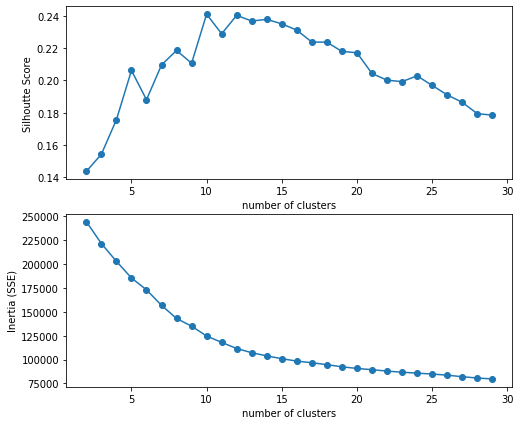

In [16]:
#%%  对主成分PCA用 KMeans分类
finding_num_cluster(pca_transform)

In [17]:
# 根据 Silhoutte Score 选择12类比较好，也可以选择9类
kmeans_model = KMeans(n_clusters = 12, random_state=42 )
preds_kmeans = kmeans_model.fit_predict( pca_transform ) 
pklsave(kmeans_model, 'sav/kmeans_model.sav')

# 整个分类流程

In [18]:
# 用已经训练好的 scaler pca kmeans 重新走一遍流程

#load
import warnings
warnings.filterwarnings('ignore')

#scaler
scaler_model = pklload('sav/scaler_model.sav')
profile_std = scaler_model.transform(profile_new)

#pca
pca_model = pklload('sav/pca_model.sav')
pca_transform = pca_model.transform(profile_std)

#kmeans
kmeans_model = pklload('sav/kmeans_model.sav')
preds_kmeans = kmeans_model.predict(pca_transform)

In [19]:
## 得到用户分类结果 放到df里  保存分类结果！！

profile_cluster = profile_new.copy()
profile_cluster['cluster'] = preds_kmeans
profile_cluster.to_csv('data/profile_cluster.csv')


## 分类结果分析

Text(0.5, 1.0, 'Profile Data')

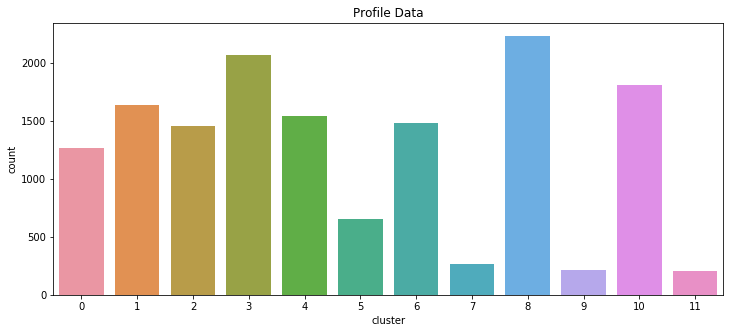

In [20]:
#%%  用户分类 做count柱状图
f,ax = plt.subplots( figsize=(12,5))
sns.countplot(profile_cluster['cluster'])
ax.set_title('Profile Data')

- 8 3 10 这几类客户最多，其次是0 1 2 4 6 这5类，5 7 9 11 这四种客户比较少
    

- 8, 3, 10 these 3 types of customers are the most, followed by the 5 types of 0, 1, 2, 4, 6, and the 4 types of 5, 7, 9, 11 are relatively few

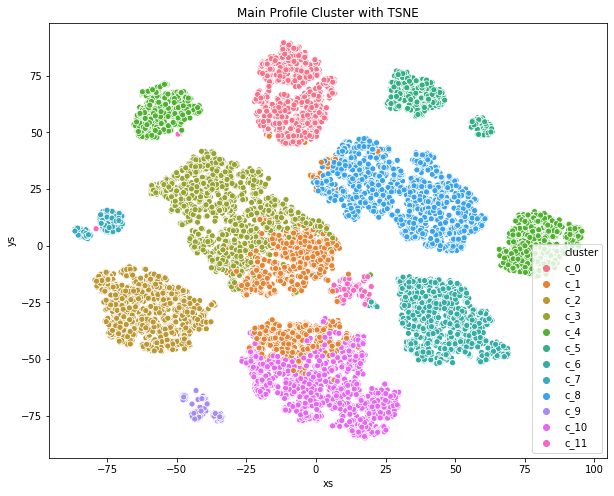

In [21]:
# TSNE 来绘制分类散点平面图

from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform( pca_transform )
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_kmeans]

#plot tsne ,这里的 range(0,12) 要和前面kmeas的分类数量一致！！！
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax,
                hue_order=['c_' + str(i) for i in range(0,12)] )
ax.set_title("Main Profile Cluster with TSNE")
#save fig
f.savefig('main_tsne.png', dpi = 300)

## 分类结果特征解释

In [22]:
# 把 Kmeans算法的中心点 返回到各个特征解释 做成 中心点-特征表

def inverse_transform_centroid(df, kmeans, pca, scaler):
    """ 
    INPUT : 
        df : dataframe
        kmeans : sklearn object of fitted KMeeans
        pca : sklearn object of fitted PCA
        scaler : sklearn object of fitted Scaler
    RETUNR :
        centers : dataframe of center value each cluster
    """
    centers = kmeans.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns= df.columns)
    return centers

In [23]:
profile_centroid = inverse_transform_centroid(profile_new, kmeans_model, pca_model, scaler_model)
profile_centroid

,age,income,avg_spending,transaction_count,sum_spending,rate_comp_rec,rate_comp_view,ofbogo_count,ofdisc_count,ofinfor_count,...,member_days_since,gender_F,gender_M,gender_O,member_year_2013,member_year_2014,member_year_2015,member_year_2016,member_year_2017,member_year_2018
0,57.015137,65862.660469,14.324135,4.653807,72.702924,0.260889,0.326391,3.892048,3.696732,1.544655,...,266.297418,1.001168,-0.000788,-0.000379,0.000890,0.002584,0.003933,0.005459,-0.002401,0.989536
1,55.571129,66435.373756,18.990783,10.752499,184.612518,0.686039,0.838824,5.626030,5.444496,0.830610,...,511.814512,0.372677,0.627643,-0.000320,0.001458,0.003612,0.005961,0.007910,0.948781,0.032278
2,54.890856,65953.366634,14.550384,11.052067,151.732269,0.456248,0.582557,4.219080,4.117402,1.529261,...,917.618205,-0.000155,1.000166,-0.000012,-0.000036,-0.000006,-0.000683,0.998786,0.000305,0.001634
3,50.239257,59006.854120,8.439373,6.721631,52.512986,0.141836,0.202149,3.286358,2.910432,1.744081,...,478.491625,-0.000861,1.000675,0.000186,-0.000870,-0.002073,-0.003619,-0.004829,1.002307,0.009084
4,54.694799,67164.093326,14.572598,11.140594,139.717687,0.424852,0.560733,4.169225,3.957667,1.506689,...,1224.546426,0.419310,0.580620,0.000071,-0.000737,-0.001502,0.997677,-0.002478,0.001890,0.005149
5,51.196539,59047.341496,8.463728,12.635208,77.034264,0.342821,0.439491,3.822385,4.097037,1.575100,...,1660.114105,0.207464,0.792331,0.000205,-0.001661,0.996454,-0.004404,-0.003897,0.004206,0.009302
6,58.580224,75760.648448,18.924346,9.802149,168.294637,0.483960,0.628655,4.224722,4.087961,1.528392,...,909.440656,0.999208,0.000610,0.000181,-0.000401,-0.001191,-0.002387,0.996234,0.001103,0.006642
7,52.324253,57571.517995,9.099327,12.598221,78.248770,0.349333,0.460356,4.032927,3.858666,1.480697,...,1922.611922,0.275099,0.724866,0.000034,0.997867,-0.004000,-0.004527,-0.002655,0.005159,0.008156
8,51.029036,56886.061306,9.225075,4.993413,38.810041,0.174923,0.215961,3.531627,3.561566,1.521918,...,262.603522,0.000809,0.999385,-0.000194,0.000585,0.001459,0.003005,0.004308,-0.001744,0.992387
9,54.441799,61805.880761,14.405831,8.149810,120.764482,0.453065,0.512457,4.074164,4.036412,1.688883,...,650.092337,0.000670,-0.000398,0.999728,0.014307,0.019705,0.138714,0.153988,0.421395,0.251891


In [24]:
# 中心点-特征表 所有特征标准化
profile_centroid_std = (profile_centroid - profile_centroid.mean()) / profile_centroid.std()

In [25]:
# 比较 不同中心点 在不同 特征上 标准化以后值，从而找到 每个特征的 最敏感人群

def compare_features(df, features, xlabel = 'cluster', ylabel = 'std value', figsize = (10,8)):
    """ This function is just to plot selected features"""
    n_cols = len(features)
    rows = n_cols//3 + (n_cols % 3 >0)
    
    f, axs = plt.subplots(rows,3, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel) 
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout() 

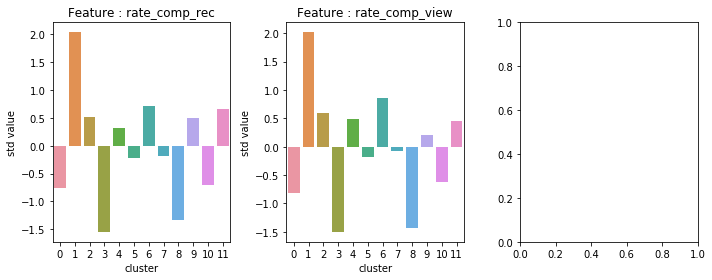

In [26]:
#%%   比较 不同类别用户 rate相关特征 

features = ['rate_comp_rec', 'rate_comp_view']
compare_features(profile_centroid_std, features, figsize=(10,4))


- complete/recieve 比值，和complete/recieve 比值 都是1类用户最高，其次是6 9 11类用户，0 3 8 10这四类用户的 offer完成率比较差
    

- The complete/recieve ratio and the complete/recieve ratio are both the highest in users of type 1 , followed by users of type 6, 9, 11, and  0, 3, 8, 10 type have relatively poor offer completion rates.

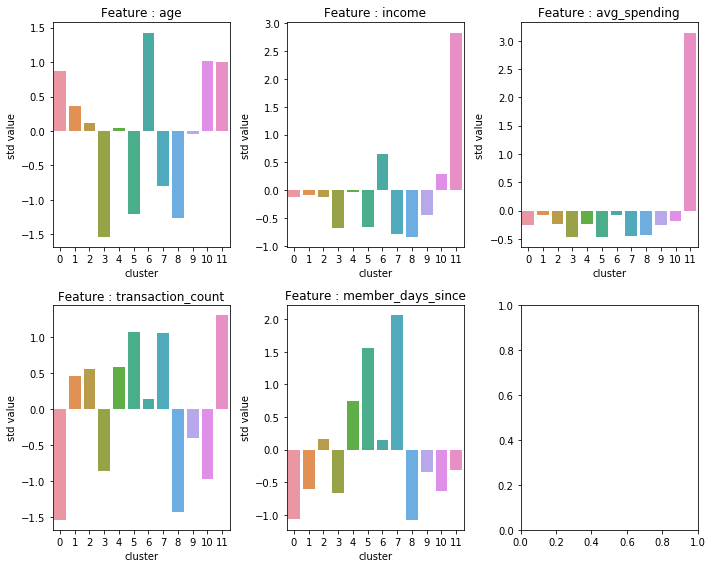

In [27]:
#%% 比较 不同类别用户 年龄 收入 交易 会员时间等

features= ['age', 'income', 'avg_spending',
           'transaction_count','member_days_since' ]

compare_features(profile_centroid_std, features, figsize=(10,8))


## 不同分类 gender与 member_year分布

In [29]:
# 用户性别分类 和用户会员时间分类  合并成一列
genders = ['gender_F','gender_M', 'gender_O']
gender_df = profile_cluster[['gender_F','gender_M', 'gender_O', 'cluster']]#.idxmax(axis=1)#.shape
# 通过 idxmax 来确定类别列中 =1 的那一列
gender_df['gender'] = gender_df[genders].idxmax(axis=1)
gender_df = gender_df.drop(genders, axis=1)

""" create member_year df """
members = profile_cluster.columns[profile_cluster.columns.str.contains('member_year')].tolist()
member_df = profile_cluster[members + ['cluster']]#.idxmax(axis=1)#.shape
member_df['member_year'] = member_df[members].idxmax(axis=1)
member_df = member_df.drop(members, axis=1)

In [32]:
gender_df.head()

,cluster,gender
Unnamed: 0,,
0610b486422d4921ae7d2bf64640c50b,10,gender_F
78afa995795e4d85b5d9ceeca43f5fef,10,gender_F
e2127556f4f64592b11af22de27a7932,8,gender_M
389bc3fa690240e798340f5a15918d5c,8,gender_M
2eeac8d8feae4a8cad5a6af0499a211d,3,gender_M


In [33]:
member_df.head()

,cluster,member_year
Unnamed: 0,,
0610b486422d4921ae7d2bf64640c50b,10,member_year_2017
78afa995795e4d85b5d9ceeca43f5fef,10,member_year_2017
e2127556f4f64592b11af22de27a7932,8,member_year_2018
389bc3fa690240e798340f5a15918d5c,8,member_year_2018
2eeac8d8feae4a8cad5a6af0499a211d,3,member_year_2017


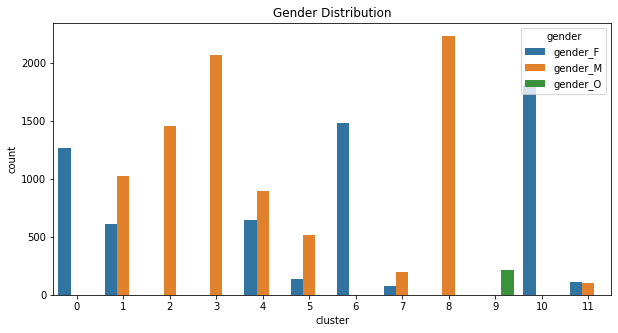

In [35]:
#  作图 不同类别 4个性别，柱状图对比

f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='gender', data= gender_df, ax=ax)
ax.set_title("Gender Distribution");

- 0 6 10这三类用户的男性最多，2 3 8这三类用户的女性最多
- 其他性别的人都在第9类用户里
    
    
- Users of types 0, 6, 10 have the most males, 2, 3, 8 types  have the most females
- People of other genders are all in the type 9 users

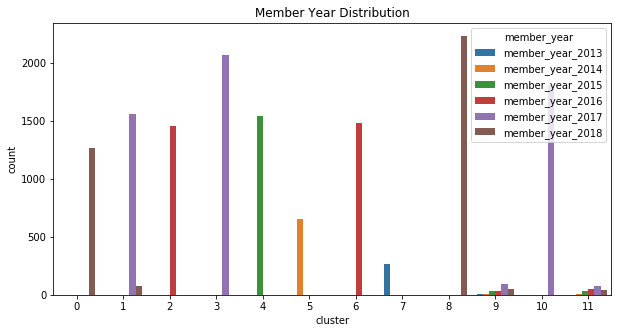

In [36]:
# 作图 不同类别 6个会员时间，柱状图对比

f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='member_year', data= member_df, ax=ax,
             hue_order = ['member_year_' + str(i) for i in range(2013,2019,1)])
ax.set_title("Member Year Distribution");
